In [1]:
import numpy as np
import torch

import torch.nn.functional as F
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

from lafomo.datasets import ToyTranscriptomics, ReactionDiffusion, HomogeneousReactionDiffusion, P53Data
from lafomo.models import NeuralOperator
from lafomo.trainers import NeuralOperatorTrainer
from lafomo.plot import Plotter, plot_spatiotemporal_data, tight_kwargs
from lafomo.utilities.data import generate_neural_dataset_1d

In [3]:
i = 3
ntest = 50
width = 20
modes = 4
in_channels = 6
block_dim = 1
learning_rate = 1e-3
batch_size = 20

dataset = ToyTranscriptomics(data_dir='../../data')
ntrain = len(dataset.train_data)
ntest = len(dataset.test_data)
train_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset.test_data, batch_size=ntest, shuffle=True)
num_outputs = 10


batch_size = 50
train_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)
if ntest > 0:
    test_loader = DataLoader(dataset.test_data, batch_size=ntest, shuffle=True)


print(ntrain, ntest)

500 10


In [4]:
model = NeuralOperator(block_dim, in_channels, modes, width)
print(model.count_params())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
trainer = NeuralOperatorTrainer(model, [optimizer], train_loader, test_loader)

44781


In [5]:
trainer.train(80);

Epoch 001/080 - Loss: 1.78 (1.41 0.52 0.74 1.26 0.67)
Epoch 002/080 - Loss: 1.01 (1.14 0.50 0.70 0.51 0.44)
Epoch 003/080 - Loss: 0.90 (1.07 0.49 0.67 0.41 0.40)
Epoch 004/080 - Loss: 0.84 (1.02 0.47 0.61 0.37 0.40)
Epoch 005/080 - Loss: 0.76 (0.83 0.41 0.45 0.35 0.38)
Epoch 006/080 - Loss: 0.65 (0.73 0.31 0.35 0.35 0.38)
Epoch 007/080 - Loss: 0.55 (0.57 0.21 0.20 0.34 0.37)
Epoch 008/080 - Loss: 0.43 (0.47 0.10 0.10 0.34 0.37)
Epoch 009/080 - Loss: 0.32 (0.51 -0.01 0.14 0.33 0.37)
Epoch 010/080 - Loss: 0.23 (0.40 -0.10 0.03 0.33 0.37)
Epoch 011/080 - Loss: 0.19 (0.40 -0.13 0.04 0.32 0.36)
Epoch 012/080 - Loss: 0.19 (0.27 -0.13 -0.09 0.32 0.36)
Epoch 013/080 - Loss: 0.12 (0.30 -0.20 -0.08 0.31 0.38)
Epoch 014/080 - Loss: 0.07 (0.29 -0.24 -0.07 0.31 0.36)
Epoch 015/080 - Loss: 0.06 (0.23 -0.24 -0.12 0.31 0.35)
Epoch 016/080 - Loss: 0.02 (0.19 -0.28 -0.16 0.30 0.35)
Epoch 017/080 - Loss: -0.01 (0.18 -0.30 -0.17 0.30 0.35)
Epoch 018/080 - Loss: -0.04 (0.15 -0.33 -0.20 0.29 0.35)
Epoch 019

In [6]:
from torch.nn.functional import softplus

def show_result(model, loader):
    x, y, params = next(iter(loader))
    out, params_out = model(x)

    t = x[0, :, 0]
    fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
    for i in range(1, 5):
        axes[0].plot(t, x[0, :, i])#.shape, y.shape)
    axes[1].plot(t, y[0, :, 0], label='Target')
    print(out[0].shape)
    mean = out[0, :, 0].detach()
    std = softplus(out[0, :, 1].detach()).sqrt()
    print(std)
    axes[1].plot(t, mean, label='Prediction')
    axes[1].fill_between(t, mean + std, mean - std, label='Target')
    axes[1].legend()
    num_params = params_out.shape[1]
    params = params.view(params.shape[0], -1)[0]
    params_out = params_out[0].detach()
    plt.figure()
    plt.bar(np.arange(num_params)-0.2, params, width=0.4)
    plt.bar(np.arange(num_params)+0.2, params_out, width=0.4)

torch.Size([11, 2])
tensor([0.1485, 0.0917, 0.1231, 0.1930, 0.2374, 0.2640, 0.3091, 0.3879, 0.3701,
        0.3387, 0.2653])
torch.Size([7, 2])
tensor([0.3102, 0.1225, 0.2410, 0.2552, 0.5156, 0.2948, 0.4727])


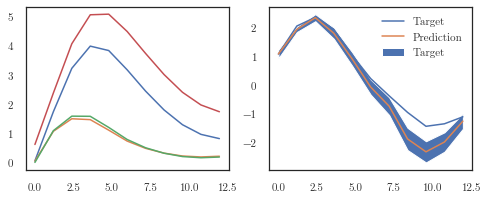

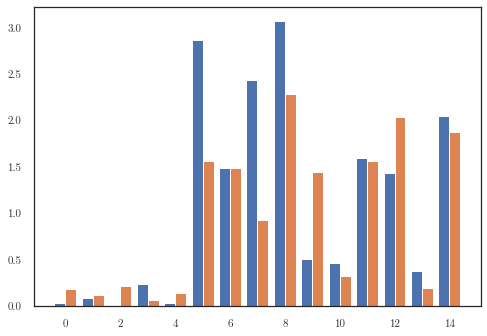

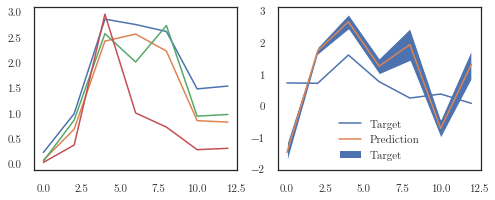

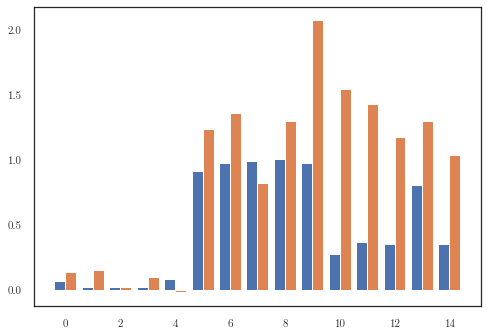

In [7]:
show_result(model, test_loader)
dataset = P53Data(data_dir='../../data', replicate=0)
train, test = generate_neural_dataset_1d(dataset.t_observed, [[dataset.m_observed, dataset.f_observed]], [dataset.params])
p53_loader = DataLoader(train, batch_size=1)
show_result(model, p53_loader)

In [9]:
show_result(model, subsampled_loader)
show_result(model, high_res_loader)

NameError: name 's' is not defined

In [ ]:
torch.save(model.state_dict(), './saved_model3205.pt')

